Use ml.m5.4xlarge and DataScience 2.0 Python 3

In [1]:
# !pip install -q transformers>=4.25.1
# !pip install -q accelerate>=0.20.3
# !pip install -q datasets>=2.11
# !pip install -q evaluate>=0.3.0
# !pip install -q peft >=0.4.0
# !pip install torch==1.13.1
# !pip install wordcloud==1.9.3
# !pip install contractions

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import os
import sys
import gzip
import json
import random
from tqdm import trange
import torch # PyTorch is a powerful deep learning library.
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from tabulate import tabulate
from sklearn.model_selection import train_test_split # for splitting data into train and test sets.
from sklearn.feature_extraction.text import TfidfVectorizer # for converting text data into vectors.
from sklearn.svm import SVC # Support Vector Machine Classifier model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score 
# above line imports different metrics to evaluate the model performance.
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes model.
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier model.
from sklearn.metrics import classification_report # for generating a comprehensive report of model performance.
from datasets import load_dataset 
# This function allows loading dataset from Huggingface's datasets library. 
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, BertForSequenceClassification

import pandas as pd
import numpy as np
import re
import json
import torch
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import sagemaker
from sagemaker.huggingface import HuggingFace
import boto3

2024-06-22 22:17:27.542961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# [Load the dataset](#Methodology)

In this step we will load the dataset into a pandas DataFrame, and explore it to understand its structure, format, and attributes in order to identify the specific column(s) or attribute(s) that contain the textual data that we will be will be working with. This dataset will be loaded from huggingface

In [3]:
import pandas as pd

# Read the CSV files
fake_news_articles = pd.read_csv('data/Fake.csv')
true_news_articles = pd.read_csv('data/True.csv')

# Assign labels: 0 for fake, 1 for true
fake_news_articles['label'] = 0
true_news_articles['label'] = 1

# Combine the two DataFrames into one
frames = [fake_news_articles, true_news_articles]
news_df = pd.concat(frames)

# Display the first few rows of the combined DataFrame
print(news_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


### News dataset

In [4]:
print(news_df.head(),"\n\n")
print("Unique labels",news_df.label.unique())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0   


Unique labels [0 1]


**Result** 

- The train and test datasets target `labels` correspond to `0 - Negative` and `1 - Positive` and a `text` field.

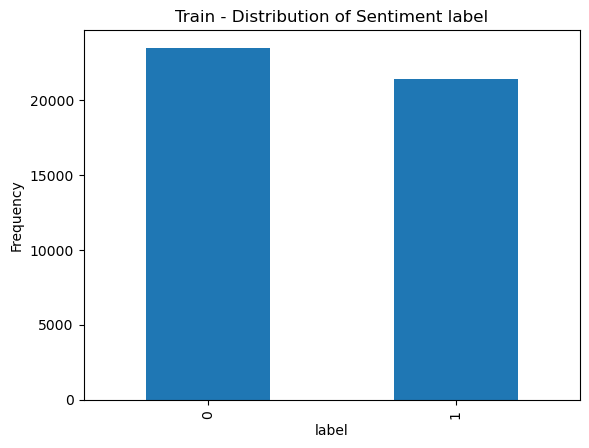

In [5]:
news_df['label'].value_counts().plot(kind='bar')
plt.title('Train - Distribution of Sentiment label')
plt.ylabel('Frequency')
plt.show()

**Result**

- The IMDB dataset has a even distribution of positive and negative reviews

### Print a random row above 95% percentile

In [6]:
# Get a random row from the dataframe
# Get the row above 95% percentile of the column news_df["Phrase"]
long_row = news_df[news_df["text"].str.len() > news_df["text"].str.len().quantile(0.98)]

random_row = long_row.sample(n=1)

# Convert the row to JSON format
long_row_json = random_row.to_json(orient='records')

# Parse the JSON string to a python dict
random_row_dict = json.loads(long_row_json)

# Print the dict in pretty format
print(json.dumps(random_row_dict[0], indent=4))
Random_ID_value = random_row.index[0]

{
    "title": "VALERIE JARRETT CLAIMS OBAMA\u2019S Presidency Was \u201cScandal-Free\u201d\u2026Here\u2019s A LIST Of Obama\u2019s Top Scandals That Prove She\u2019s Lying [VIDEO]",
    "text": " The president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  Jarrett said in an interview broadcast on CNN Sunday.The aide, also a close friend of Obama and his wife, Michelle, credited the first couple with being good people and getting good results. That s because that s who he is   that s who they are   and I think that s what really resonates with the American people,  Jarrett said.Critics of the Obama administration said Jarrett was trying to rewrite history.  NYPThe great  stimulus  heist: Obama seems to think nobody will remember he grabbed almost a trillion dollars for  stimulus  spending, created virtually zero private-sector jobs with it, allowed a great deal of the money to vanish into thin air, and spent 

In [7]:
print(Random_ID_value)

19365


**result**
- On printing random row we see that the text fields are not clean, we will perform data to clean up punctuations, stop words, ASCII characters, dates etc. 

### Text Length Analysis

Calculate the length of each review and analyze the distribution of lengths to garner insights into the average length of reviews, the trange of lengths, etc.

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text, dtype: float64


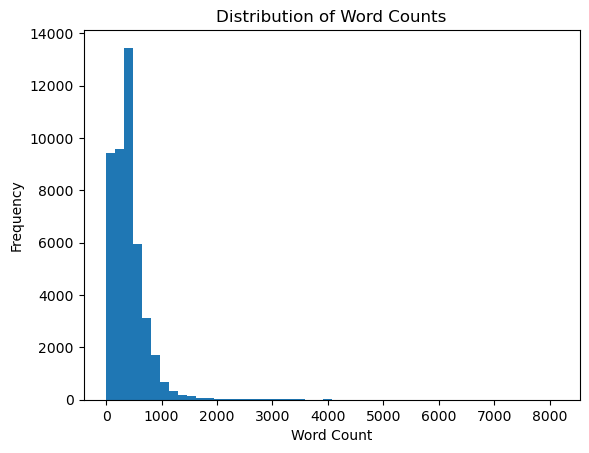

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Print out a summary of the word count statistics
print(news_df['text'].apply(word_count).describe())

# Plot a histogram of the word counts
plt.hist(news_df['text'].apply(word_count), bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**Result**
- The distribution shows the word count tranges from 4 words to 2,278 with an average of 228 words and a standard deviation of 168.

# [Apply Word2vec for Semantec Analsyis, Key Word and Topic analsysis](#Methodology)

We will use word2vec for semantic analysis to perform keyword extraction and gain insights into the main topics and themes discussed in the reviews.

Word2vec represents words as vectors in a high-dimensional space, capturing their semantic relationships. This allows us to identify key words that are closely related to the main topics and themes in the reviews. This will help us extract more meaningful insights from the text data and overcome the limitations of using simple frequency-based methods like TF-IDF.


In [9]:
!pip install gensim

In [10]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['text'].tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

**result**

- In our first pass at keyword analsisys, we find that the most common word were stop words, specifically `the` is the most common word followed by `and` and `of`. We will review this results after cleaning up the datasets

# [Cleaning the Dataset]((#Methodology))

In this section, we will perform text cleaning that will involve several processes. The first process is fixing contractions. Contractions are words or combinations of words that are shortened by dropping letters and replacing them with an apostrophe. For example, "don't" is a contraction of "do not". Fixing these contractions will ensure that our text data is consistent and easier to analyze. 

The next process is removing non-ASCII characters. ASCII characters are the standard characters in the English language, including all letters, numbers, and common symbols. Non-ASCII characters include special symbols and characters from other languages. Removing these will ensure that our text data only contains standard English characters.

The third process is converting all text to lowercase. This is important because in text analysis, 'Word' and 'word' are considered as two different words due to the difference in case. By converting everything to lowercase, we can avoid this issue and make our analysis more accurate.

The final process is removing punctuations. Punctuations can cause issues in text analysis as they can create different tokens or words. For example, 'word,' and 'word' would be considered as two different words due to the comma. By removing punctuations, we can avoid this issue and make our text data cleaner and easier to analyze.

### Contractions

We used the [contractions](https://github.com/kootenpv/contractions) package to resolve contractions and  (and slang), `examples:you're -> you are`



In [11]:
import contractions
news_df["text_clean"] = news_df['text'].apply(lambda x: contractions.fix(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' The president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  Jarrett said in an interview broadcast on CNN Sunday.The aide'

### Remove URLs
Remove URL from text

In [12]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_URL(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' The president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  Jarrett said in an interview broadcast on CNN Sunday.The aide'

### Remove Non-ASCI Characters

In [13]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_non_ascii(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' The president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  Jarrett said in an interview broadcast on CNN Sunday.The aide'

### Make characters lowercase

In [14]:
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: x.lower())
news_df.iloc[Random_ID_value]['text_clean'][:200]

' the president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  jarrett said in an interview broadcast on cnn sunday.the aide'

### Remove html

In [15]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_html(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' the president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  jarrett said in an interview broadcast on cnn sunday.the aide'

### Remove symbols

In [16]:
def remove_symbols(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_symbols(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' the president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  jarrett said in an interview broadcast on cnn sunday.the aide'

### Remove Special characters

In [17]:
def remove_special_chars(text):
    """
        Remove special characters (\n, \, ', "",) in sample text
    """
    # Replace \n, \ and ' with empty string
    text = text.replace('\n', ' ').replace('\\', ' ').replace('\'', ' ').replace('\"', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ')
    return text

# Assuming news_df is a DataFrame with a column "text_clean" containing text data
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_special_chars(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' the president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself,  jarrett said in an interview broadcast on cnn sunday.the aide'

### Remove punctuations

In [18]:
import re
def remove_punct(text):

    # Replace punctuation with space, except for decimal points in numerical values
    return re.sub(r'(?:(?<!\d)[.,;()]|[.,;()](?!\d))', '', text)

# Apply the function to the dataframe
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_punct(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

' the president prides himself on the fact that his administration hasn t had a scandal and he hasn t done something to embarrass himself  jarrett said in an interview broadcast on cnn sundaythe aide a'

**result**
- In removing punctuations, we needed to be carefull not to remove punctuations in between numbers in order to preseve the information in text, doing so would have caused values such as `12.4 million` -> `124 million` which would have changed the meaning of the text

# [Text Preprocessing](#Methodology)

In this section, we will perform text preprocessing that will involve several steps. First, we will carry out tokenization on the textual data. This process involves splitting the text into individual tokens, which could be words, punctuation, or other meaningful units. We will use an appropriate tokenization technique or library to achieve this. 

Next, we will remove stop words from the tokenized text. Stop words are common words such as "the," "is," "and" that do not carry significant meaning. We will use a standard stop word list or library to identify and remove these words from our text. 

Following this, we will apply stemming to the tokens. Stemming is a process that reduces each word to its base or root form. We will use a suitable stemming algorithm or library to perform this task. 

Finally, we will implement lemmatization on the tokens. Lemmatization is a process that transforms each word into its canonical or dictionary form. We will use a reliable lemmatization technique or library for this purpose. 

### Tokenization

Tokenization is the process of breaking down text into smaller parts called tokens which help in understanding the context or developing the model for NLP (Natural Language Processing). The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words. 

For instance, consider the text "The quick brown fox jumps over the lazy dog". In tokenization, this sentence is broken down into individual words: 'The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'.

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
import nltk
from nltk.tokenize import word_tokenize

news_df['tokenized'] = news_df['text_clean'].apply(word_tokenize)
news_df.iloc[Random_ID_value]['tokenized'][:200]

['the',
 'president',
 'prides',
 'himself',
 'on',
 'the',
 'fact',
 'that',
 'his',
 'administration',
 'hasn',
 't',
 'had',
 'a',
 'scandal',
 'and',
 'he',
 'hasn',
 't',
 'done',
 'something',
 'to',
 'embarrass',
 'himself',
 'jarrett',
 'said',
 'in',
 'an',
 'interview',
 'broadcast',
 'on',
 'cnn',
 'sundaythe',
 'aide',
 'also',
 'a',
 'close',
 'friend',
 'of',
 'obama',
 'and',
 'his',
 'wife',
 'michelle',
 'credited',
 'the',
 'first',
 'couple',
 'with',
 'being',
 'good',
 'people',
 'and',
 'getting',
 'good',
 'results',
 'that',
 's',
 'because',
 'that',
 's',
 'who',
 'he',
 'is',
 'that',
 's',
 'who',
 'they',
 'are',
 'and',
 'i',
 'think',
 'that',
 's',
 'what',
 'really',
 'resonates',
 'with',
 'the',
 'american',
 'people',
 'jarrett',
 'saidcritics',
 'of',
 'the',
 'obama',
 'administration',
 'said',
 'jarrett',
 'was',
 'trying',
 'to',
 'rewrite',
 'history',
 'nypthe',
 'great',
 'stimulus',
 'heist',
 ':',
 'obama',
 'seems',
 'to',
 'think',
 'nobo

**result**
- On tokenization, we find that `word_tokenize` does not catch numbers such as `175m` which represents 175 million. Since the NLP downstream task is sentiment, analysis these definitions of tokens are fine and can be left as is

### Remove stop words

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Removing stopwords.
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
news_df['stopwords_removed'] = news_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['president',
 'prides',
 'fact',
 'administration',
 'scandal',
 'done',
 'something',
 'embarrass',
 'jarrett',
 'said',
 'interview',
 'broadcast',
 'cnn',
 'sundaythe',
 'aide',
 'also',
 'close',
 'friend',
 'obama',
 'wife',
 'michelle',
 'credited',
 'first',
 'couple',
 'good',
 'people',
 'getting',
 'good',
 'results',
 'think',
 'really',
 'resonates',
 'american',
 'people',
 'jarrett',
 'saidcritics',
 'obama',
 'administration',
 'said',
 'jarrett',
 'trying',
 'rewrite',
 'history',
 'nypthe',
 'great',
 'stimulus',
 'heist',
 ':',
 'obama',
 'seems',
 'think',
 'nobody',
 'remember',
 'grabbed',
 'almost',
 'trillion',
 'dollars',
 'stimulus',
 'spending',
 'created',
 'virtually',
 'zero',
 'private',
 'sector',
 'jobs',
 'allowed',
 'great',
 'deal',
 'money',
 'vanish',
 'thin',
 'air',
 'spent',
 'rest',
 'presidency',
 'complaining',
 'needed',
 'hundreds',
 'billions',
 'repair',
 'roads',
 'bridgesvast',
 'sums',
 'taxpayer',
 'money',
 'wasted',
 'foolish',
 'pr

count    44898.000000
mean       240.672836
std        210.325345
min          0.000000
25%        123.000000
50%        212.000000
75%        302.000000
max       5107.000000
Name: word_count, dtype: float64


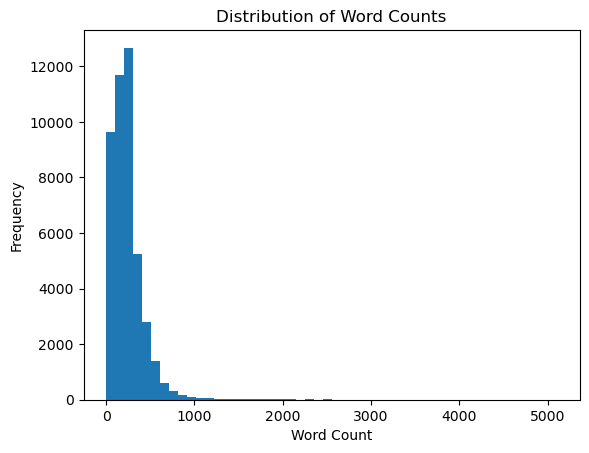

In [23]:
# Apply the join function to the 'stopwords_removed' column
news_df['word_count'] = news_df['stopwords_removed'].apply(' '.join).apply(word_count)

# Print out a summary of the word count statistics
print(news_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(news_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**result**
- After removing the stop words, maximum length of `text` goes from 4 to 1178 words. 

In [24]:
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['president',
 'prides',
 'fact',
 'administration',
 'scandal',
 'done',
 'something',
 'embarrass',
 'jarrett',
 'said',
 'interview',
 'broadcast',
 'cnn',
 'sundaythe',
 'aide',
 'also',
 'close',
 'friend',
 'obama',
 'wife',
 'michelle',
 'credited',
 'first',
 'couple',
 'good',
 'people',
 'getting',
 'good',
 'results',
 'think',
 'really',
 'resonates',
 'american',
 'people',
 'jarrett',
 'saidcritics',
 'obama',
 'administration',
 'said',
 'jarrett',
 'trying',
 'rewrite',
 'history',
 'nypthe',
 'great',
 'stimulus',
 'heist',
 ':',
 'obama',
 'seems',
 'think',
 'nobody',
 'remember',
 'grabbed',
 'almost',
 'trillion',
 'dollars',
 'stimulus',
 'spending',
 'created',
 'virtually',
 'zero',
 'private',
 'sector',
 'jobs',
 'allowed',
 'great',
 'deal',
 'money',
 'vanish',
 'thin',
 'air',
 'spent',
 'rest',
 'presidency',
 'complaining',
 'needed',
 'hundreds',
 'billions',
 'repair',
 'roads',
 'bridgesvast',
 'sums',
 'taxpayer',
 'money',
 'wasted',
 'foolish',
 'pr

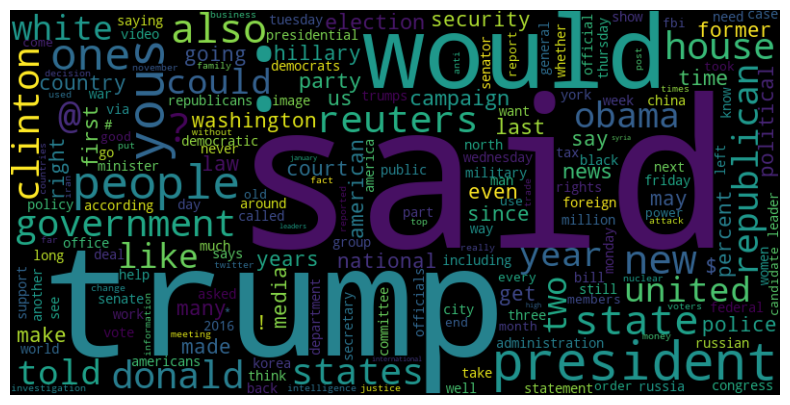

In [25]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['stopwords_removed'].apply(' '.join).tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**result**
- After incoperating the stop word removal, we noticed that have a key words now related to `movie`, `film` , `one` and `good`. 

# [Train and test datasets](#Methodology)

In [26]:
### Import Models

In [27]:
# Tokenize
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512, force_download=True)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [28]:
news_df["stopwords_removed"] = news_df["stopwords_removed"].apply(' '.join)

In [29]:
text = news_df['stopwords_removed']
labels = torch.from_numpy(np.array(news_df.label))

**BERT requires the following preprocessing steps**


Incorporate special tokens:
- Commence each sentence with a [CLS] token (identified as 101)
- Conclude each sentence with a [SEP] token (identified as 102)

Achieve uniform sentence lengths:
- Padding is employed to equalize shorter sequences to the required length by adding convenience values. Longer sequences are shortened.
- Padding tokens, known as [PAD], are recognized as ID 0.
- The permissible maximum sequence length is 512 tokens.

Develop an attention mask:
- A list of binary values (0s and 1s) indicating whether the model should take into account certain tokens while learning their contextual representation. Padding ([PAD]) tokens are expected to have a value of 0.
This process can be visualized as follows:  


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*vaw98m1VVncgKxNFWI0d2Q.png" alt="drawing" width="800"/>

We will use a very helpfull function [encode_plus](https://huggingface.co/docs/transformers/main_classes/tokenizer?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus) provided in the Tokenizer class to procepcessing.


--- 

### Tokenization

In [30]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_24078/1155887400.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [31]:
def print_shortest_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of the shortest text sample'''
  
  # Get the length of each sentence in the dataset
  sentence_lengths = [len(s) for s in token_id]
  
  # Find the index of the shortest sentence
  shortest_index = np.argmin(sentence_lengths)
  
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[shortest_index]))
  token_ids = [i.item() for i in token_id[shortest_index]]
  attention = [i.item() for i in attention_masks[shortest_index]]

  table = np.array([tokens, token_ids, attention]).T[:180]
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_shortest_sentence_encoding()

╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ donald     │        6221 │                1 │
├────────────┼─────────────┼──────────────────┤
│ trump      │        8398 │                1 │
├────────────┼─────────────┼──────────────────┤
│ wish       │        4299 │                1 │
├────────────┼─────────────┼──────────────────┤
│ americans  │        4841 │                1 │
├────────────┼─────────────┼──────────────────┤
│ happy      │        3407 │                1 │
├────────────┼─────────────┼──────────────────┤
│ new        │        2047 │                1 │
├────────────┼─────────────┼──────────────────┤
│ year       │        2095 │                1 │
├────────────┼─────────────┼──────────────────┤
│ leave      │        2681 │                1 │
├────────────┼─────────────┼────────────

# Save to S3

In [32]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Assuming news_df is your original DataFrame
# Remove rows with null values in 'stopwords_removed'
news_df = news_df.dropna(subset=['stopwords_removed'])

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(news_df[['stopwords_removed', 'label']])

# Shuffle the dataset
hf_dataset = hf_dataset.shuffle(seed=42)

# Split the dataset
train_test_split = hf_dataset.train_test_split(test_size=0.3)  # Split into 70% train, 30% test/validation

# Further split the test/validation set into 50% test and 50% validation
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5)

# Combine splits into a DatasetDict
split_dataset = DatasetDict({
    'train': train_test_split['train'],
    'test': test_valid_split['test'],
    'hold_back': test_valid_split['train']
})

# Verify the splits
print(split_dataset)


DatasetDict({
    train: Dataset({
        features: ['stopwords_removed', 'label', '__index_level_0__'],
        num_rows: 31428
    })
    test: Dataset({
        features: ['stopwords_removed', 'label', '__index_level_0__'],
        num_rows: 6735
    })
    hold_back: Dataset({
        features: ['stopwords_removed', 'label', '__index_level_0__'],
        num_rows: 6735
    })
})


In [33]:
def tokenize(batch):
    return tokenizer(batch['stopwords_removed'], 
                      padding='max_length', 
                      truncation=True) 

In [34]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']
hold_back_dataset = split_dataset['hold_back']

In [35]:
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
hold_back_dataset = hold_back_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [36]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'fake-news-dataset'
train_path = f's3://{bucket}/{prefix}/train'
test_path = f's3://{bucket}/{prefix}/test'
hold_back = f's3://{bucket}/{prefix}/hold_back'

In [37]:
def save_dataset_to_s3(dataset_path, bucket, prefix):
    s3 = boto3.client('s3')
    for root, _, files in os.walk(dataset_path):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, dataset_path)
            s3_path = f'{prefix}/{relative_path}'
            s3.upload_file(local_path, bucket, s3_path)

In [38]:

train_dataset.save_to_disk('train_dataset')  # Save locally first
test_dataset.save_to_disk('test_dataset')   # Save locally first
test_dataset.save_to_disk('hold_back')   # Save locally first
save_dataset_to_s3('train_dataset', bucket, f'{prefix}/train')  
save_dataset_to_s3('test_dataset', bucket, f'{prefix}/test')
save_dataset_to_s3('hold_back', bucket, f'{prefix}/hold_back')


Saving the dataset (0/1 shards):   0%|          | 0/31428 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6735 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6735 [00:00<?, ? examples/s]

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Setup Experiment

In [40]:
from datetime import datetime
import uuid
from sagemaker.experiments.run import Run
time_suffix = datetime.now().strftime('%y%m%d%H%M')
rand_id = uuid.uuid4().hex[:5] # this is the random-id assigned for each run. 
experiments_name = f"exp-{model_name.replace('/', '-')}"
run_name = f"run-name-of-{experiments_name}-{time_suffix}-{rand_id}"
job_name = run_name


model_eval_s3_loc = f"s3://{bucket}/{run_name}/modeleval"
model_output_s3_loc = f"s3://{bucket}/{run_name}/modeloutput"

print(f"SageMaker experiment name: {experiments_name}")
print(f"SageMaker experiment run name: {run_name}")
print(f"SageMaker training job name: {job_name}")

SageMaker experiment name: exp-prajjwal1-bert-tiny
SageMaker experiment run name: run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4
SageMaker training job name: run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4


In [41]:
# Training with Hugging Face on SageMaker
hyperparameters = {
    'epochs': 1,
    'train_batch_size': 64,
    'model_id': model_name,
}

In [42]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}
]

# Start Training Run

In [43]:
with Run(
    experiment_name=experiments_name,
    run_name=run_name,
    sagemaker_session=sagemaker_session
) as run:

    # create the Estimator
    huggingface_estimator = HuggingFace(
        entry_point='train.py',         # train script
        source_dir='./scripts',         # directory which includes all the files needed for training
        instance_type='ml.m5.xlarge', # instances type used for the training job
        instance_count=1,               # the number of instances used for training
        base_job_name=job_name,         # the name of the training job
        role=sagemaker.get_execution_role(),      # Iam role used in training job to access AWS ressources, e.g. S4
        pytorch_version='1.13',          # the pytorch_version version used in the training job
        py_version='py39',             # the python version used in the training job
        transformers_version='4.26',
        hyperparameters= hyperparameters,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        logging_dir='./logs',
        logging_steps=10,
        image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.13.1-transformers4.26.0-gpu-py39-cu117-ubuntu20.04",
        sagemaker_session=sagemaker_session,         # specifies a sagemaker session object
        output_path=model_output_s3_loc, # s3 location for model artifact,
        # metric_definitions=metric_definitions,
    )
    
    # define a data input dictonary with our uploaded s3 uris
    data = { 'train': train_path,
             'test': test_path}
    # starting the train job with our uploaded datasets as input
    huggingface_estimator.fit(data, wait=True, logs= 'all')
    run.log_parameters(data)

INFO:sagemaker:Creating training-job with name: run-name-of-exp-prajjwal1-bert-tiny-240-2024-06-22-22-23-11-133


2024-06-22 22:23:11 Starting - Starting the training job...
2024-06-22 22:23:26 Starting - Preparing the instances for training...
2024-06-22 22:23:52 Downloading - Downloading input data...
2024-06-22 22:24:27 Downloading - Downloading the training image..................
2024-06-22 22:27:28 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-22 22:27:37,967 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-22 22:27:37,969 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-22 22:27:37,971 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-22 22:27:37,982 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-06-22 22:27:37,986 sagemaker_pytorch_container.training INFO     Invoking

In [44]:
# huggingface_estimator.fit({'train': train_path, 'test': test_path})

# Accessing Training Metrics

In [45]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=huggingface_estimator.latest_training_job.name).dataframe()
df.head(10)

KeyError: 'MetricDefinitions'

In [ ]:
!pip install seaborn

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

# Serving

In [46]:
model_path = huggingface_estimator.model_data
print(f"Model artifact saved at: {model_path}")

Model artifact saved at: s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/modeloutput/run-name-of-exp-prajjwal1-bert-tiny-240-2024-06-22-22-23-11-133/output/model.tar.gz


In [ ]:
# from sagemaker.huggingface import HuggingFaceModel

# # Define the Hugging Face model
# huggingface_model = HuggingFaceModel(
#     model_data=model_path,
#     role=sagemaker.get_execution_role(),
#     transformers_version='4.6',        # Transformers version
#     pytorch_version='1.7',             # PyTorch version
#     py_version='py36',                 # Python version
#     entry_point='inference.py',         # Your inference script
#     source_dir='./scripts',
# )

# # Deploy the model
# predictor = huggingface_model.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m5.xlarge'
# )

In [ ]:
# # Testing the model
# random_sample = news_df.sample(n=1)
# test_text = random_sample['stopwords_removed'].values[0]
# prediction = predictor.predict({"inputs": test_text[:512]})
# print(f"Text: {test_text}")
# print(f"Prediction: {prediction}")

In [ ]:
# # Delete endpoint
# predictor.delete_model()
# predictor.delete_endpoint()

We create a metric_definition dictionary that contains regex-based definitions that will be used to parse the job logs and extract metric

# Sagemaker Monitoring

In [47]:
from sagemaker.model import Model 
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer
from threading import Thread 

# Convert hold back data to ground truth and production data

In [48]:
baseline_prefix = "./baseline"

# Convert to DataFrame for easier manipulation
df_hold_back = hold_back_dataset.to_pandas()

# Limit to 200 entries
df_hold_back_limited = df_hold_back.head(250)

# Create Ground_truth DataFrame (include text and label)
ground_truth_df = df_hold_back_limited[['stopwords_removed', 'label']].copy()
ground_truth_df.columns = ['text', 'label']

# Create Production_data DataFrame (include only text)
production_data_df = df_hold_back_limited[['stopwords_removed']].copy()
production_data_df.columns = ['text']

# Add index for traceability if necessary
ground_truth_df.reset_index(drop=True, inplace=True)
production_data_df.reset_index(drop=True, inplace=True)

# Save both DataFrames to CSV files
ground_truth_path = f'{baseline_prefix}/ground_truth.csv'
production_data_path = f'{baseline_prefix}/production_data.csv'

ground_truth_df.to_csv(ground_truth_path, index=False)
production_data_df.to_csv(production_data_path, index=False)

print(f"Ground truth saved to {ground_truth_path}")
print(f"Production data saved to {production_data_path}")

Ground truth saved to ./baseline/ground_truth.csv
Production data saved to ./baseline/production_data.csv


In [49]:
ground_truth_df.head()

,text,label
0,first time obama left important figure behind ...,0
1,berlin reuters three germany main parties rais...,1
2,story fade quickly back page news mainstream m...,0
3,new delhi reuters indian police arrested chris...,1
4,john kerry : injured credibility conceivably i...,0


In [50]:
production_data_df.head()

,text
0,first time obama left important figure behind ...
1,berlin reuters three germany main parties rais...
2,story fade quickly back page news mainstream m...
3,new delhi reuters indian police arrested chris...
4,john kerry : injured credibility conceivably i...


# Deploy Data Capture

In [51]:
# Capture Path
capture_path = f"s3://{bucket}/{run_name}/capture_path"
# Ground Truth Path 
ground_truth= f"s3://{bucket}/{run_name}/ground_truth"
print(capture_path)
print(ground_truth)

s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path
s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/ground_truth


In [52]:
data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=capture_path
)

In [53]:
from sagemaker.huggingface import HuggingFaceModel

# Define the Hugging Face model
huggingface_model = HuggingFaceModel(
    model_data=model_path,
    role=sagemaker.get_execution_role(),
    transformers_version='4.6',        # Transformers version
    pytorch_version='1.7',             # PyTorch version
    py_version='py36',                 # Python version
    entry_point='inference.py',         # Your inference script
    source_dir='./scripts',
)

# Deploy the model
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge', 
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/modeloutput/run-name-of-exp-prajjwal1-bert-tiny-240-2024-06-22-22-23-11-133/output/model.tar.gz), script artifact (./scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-873309100258/huggingface-pytorch-inference-2024-06-22-22-50-08-137/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2024-06-22-22-50-13-552
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2024-06-22-22-50-14-249
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2024-06-22-22-50-14-249


-----!

In [54]:
endpoint_name = predictor.endpoint_name
print(endpoint_name)

huggingface-pytorch-inference-2024-06-22-22-50-14-249


### Test the endpoint

In [55]:
from sagemaker.serializers import JSONSerializer

predictor.serializer = JSONSerializer()

random_sample = news_df.sample(n=1)
test_text = random_sample['stopwords_removed'].values[0]
# Assuming the model endpoint expects a JSON formatted input with the key "inputs"
prediction = predictor.predict({"inputs": test_text[:512]})
print(f"Text: {test_text}")
print(f"Prediction: {prediction}")


Text: paris reuters france monday urged chadian authorities press ahead parliamentary elections securing billions dollars pledges donor countries aimed helping revive country struggling economy president idriss deby elected 2016 gaining power 1990 head armed rebellion said february lack financial resources meant chad parliamentary elections would postponed indefinitely legislative elections important moment democratic life french foreign ministry spokeswoman agnes romatet espagne told reporters daily briefing hope regard chadian authorities position announce calendar elections soon statement friday chad government said secured $ 18.5 billion pledges 2017 2021 national development program double original expectations romatet espagne said france would contribute 223 million euros $ 267.27 million former french colony one poorest nations world rocked humanitarian crises past decade including conflicts east south drought arid sahel region flooding compounded since 2012 instability borders 

# Create a basline: Execute predications using the validation dataset

# Create Sagemaker Predictor Object

In [56]:
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sagemaker_session, serializer=CSVSerializer()
)

In [57]:
import json
import time
import pandas as pd
from sagemaker.serializers import JSONSerializer


churn_cutoff = 0.80
base_line_data = f"{baseline_prefix}/base_line_data.csv"
ground_truth_data = f"{baseline_prefix}/ground_truth.csv"

predictor.serializer = JSONSerializer()

limit = 250  # Need at least 200 samples to compute standard deviations
i = 0

# Read the ground_truth.csv file into a pandas DataFrame
df = pd.read_csv(ground_truth_data)

try:
    with open(base_line_data, "w") as baseline_file:
        baseline_file.write("confidence_score,predicted_label,ground_truth_label,confidence_cutoff\n")  # our header
        
        for index, row in df.iterrows():
            text = row['text']
            label = row['label']   
            
            # Ensure text is a string and not empty
            if not isinstance(text, str) or text.strip() == "":
                continue  # Skip rows where text is not a string or is empty
                
            prediction_result = predictor.predict({"inputs": text[:512]})
            
            # Parse the JSON prediction result
            prediction_json = json.loads(prediction_result.decode('utf-8'))[0]
            confidence_score = prediction_json['score']
            prediction = "1" if prediction_json['label'] == "positive" else "0"
            confidence_cutoff = "1" if confidence_score > churn_cutoff else "0"
            
            baseline_file.write(f"{confidence_score},{prediction},{label},{confidence_cutoff}\n")
            i += 1
            if i >= limit:
                break
            print(".", end="", flush=True)
            time.sleep(0.5)
    print()
    print("Done!")
except Exception as e:
    print(f"An error occurred: {e}")


......................................................................................................................................................................................................................................................
Done!


In [58]:
!head base_line_data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
head: cannot open 'base_line_data' for reading: No such file or directory


### update the baseline data to s3

In [59]:
baseline_data_prefix = (baseline_prefix + "/data").strip("./")
baseline_results_prefix = (baseline_prefix + "/results").strip("./")

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-873309100258/baseline/data
Baseline results uri: s3://sagemaker-us-east-1-873309100258/baseline/results


In [60]:
prefix = 'baseline'

# Use the function to upload the baseline data
save_dataset_to_s3(baseline_prefix, bucket, baseline_data_prefix)

print(f"Baseline data uploaded to s3://{bucket}/{baseline_data_prefix}/")

Baseline data uploaded to s3://sagemaker-us-east-1-873309100258/baseline/data/


#### 3.4 Create a baselining job with validation dataset predictions
Define the model quality monitoring object and execute the model quality monitoring baseline job. Model monitor will automatically generate baseline statistics and constraints based on the validation dataset provided.

In [61]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [62]:
# Name of the model quality baseline job
time_suffix = datetime.now().strftime('%y%m%d%H%M')
baseline_job_name = f"bert-fake-news-prediction-baseline-job-{time_suffix}"

In [63]:
# Create the model quality monitoring object
fake_news_labeler_quality_monitor = ModelQualityMonitor(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker_session,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [64]:
# Execute the baseline suggestion job.
job = fake_news_labeler_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=f'{baseline_data_uri}/base_line_data.csv',
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="predicted_label",
    # probability_attribute="confidence_score",
    ground_truth_attribute="ground_truth_label",
)

# Wait for the job to complete and display logs
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name bert-fake-news-prediction-baseline-job-2406222256


...........................................................!

#### 3.5 Explore the results of the baselining job
You could see the baseline constraints and statistics files are uploaded to the S3 location

In [65]:
baseline_job = fake_news_labeler_quality_monitor.latest_baselining_job

In [66]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,138.000000
confusion_matrix.0.1,3.000000
confusion_matrix.1.0,0.000000
confusion_matrix.1.1,105.000000
recall.value,1.000000
recall.standard_deviation,0.000000
precision.value,0.972222
precision.standard_deviation,0.009016
accuracy.value,0.987805
accuracy.standard_deviation,0.003827


##### 3.5.2 View the constraints generated

In [67]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,1.0,LessThanThreshold
precision,0.972222,LessThanThreshold
accuracy,0.987805,LessThanThreshold
true_positive_rate,1.0,LessThanThreshold
true_negative_rate,0.978723,LessThanThreshold
false_positive_rate,0.021277,GreaterThanThreshold
false_negative_rate,0.0,GreaterThanThreshold
f0_5,0.977654,LessThanThreshold
f1,0.985915,LessThanThreshold
f2,0.994318,LessThanThreshold


# 4. Setup continous Monitoring

#### 4.1 Generate prediction data for Model Quality  Monitoring

Start generating some artificial traffic.

Start generating some artificial traffic, start from row 300 - 400

In [69]:
# Starting from row 300
df_subset = production_data_df.iloc[300:400]

# Save this subset to a temporary CSV file
temp_production_data = f"{baseline_prefix}/temp_production_data.csv"
df_subset.to_csv(temp_production_data, index=False, header=False)

def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)

def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, temp_production_data)
        except sagemaker_session.sagemaker_runtime_client.exceptions.ValidationError:
            pass

# Start the invocation in a separate thread
thread = Thread(target=invoke_endpoint_forever)
thread.start()

# Let it run for a certain amount of time (e.g., 5 minutes)
import time
time.sleep(300)

# Stop the thread (you might need to implement a way to stop the thread safely)
# For now, we'll just let it run and you can manually interrupt it

print("Endpoint invocation started. It will continue running until you manually stop it.")

Endpoint invocation started. It will continue running until you manually stop it.


#### 4.2 View captured data

Now list the data capture files stored in Amazon S3.

In [70]:
print(capture_path)

s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path


In [71]:
from sagemaker.s3 import S3Downloader
from time import sleep

capture_file = []

capture_uri = capture_path
print("Waiting for captures to show up", end="")
for _ in range(2):  # Wait for 10 minutes
    # Construct the complete capture path with timestamp
    capture_files = sorted(S3Downloader.list(capture_uri))
    if capture_files:
        print(f"\n Found Capture Files: {capture_files}")
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        for line in capture_file:
            if line:  # Skip empty lines
                capture_record = json.loads(line)
                if "inferenceId" in capture_record["eventMetadata"]:
                    print("\nFound inferenceId in captured data.")
                    break  # Exit the loop if inferenceId is found
    print(".", end="", flush=True)
    sleep(1)
print()

Waiting for captures to show up
 Found Capture Files: ['s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/53-43-482-0186b8a1-01ad-40f3-8acc-6fa226c585e5.jsonl', 's3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/54-43-642-4976ec4c-967a-4753-947d-1a157f674c0e.jsonl', 's3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/55-44-048-3e9fd097-7e5f-4212-90ba-df753c6709d3.jsonl']
.
 Found Capture Files: ['s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/53-43-482-0186b8a1-

In [73]:
if capture_file:
    print("Found Capture Files:")
    print("\n ".join(capture_files[-3:]))

    # # View contents of a capture file
    # print("\n".join(capture_file[-3:-1]))

    # View a single line in a capture file
    print(json.dumps(capture_record, indent=2))
else:
    print("No Capture Files found within the time limit")

Found Capture Files:
s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/53-43-482-0186b8a1-01ad-40f3-8acc-6fa226c585e5.jsonl
 s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/54-43-642-4976ec4c-967a-4753-947d-1a157f674c0e.jsonl
 s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/capture_path/huggingface-pytorch-inference-2024-06-22-22-50-14-249/AllTraffic/2024/06/22/22/55-44-048-3e9fd097-7e5f-4212-90ba-df753c6709d3.jsonl
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "{\"inputs\": \"washington reuters bernie sanders high flying democratic presidential campaign fell back earth saturday nevada vermont sena

#### 4.3 Generate synthetic ground truth

Next, start generating ground truth data. The model quality job will fail if there's no ground truth data to merge.

In [74]:
import random
from sagemaker.s3 import S3Uploader
import pandas as pd

# Load the ground truth data
ground_truth_data = pd.read_csv(f"{baseline_prefix}/ground_truth.csv")

def ground_truth_with_id(row):
    return {
        "groundTruthData": {
            "data": str(row['label']),  # Use the 'label' column from the DataFrame
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(row.name),  # Use row index as eventId
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)



NUM_GROUND_TRUTH_RECORDS = len(ground_truth_data)


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        # Create ground truth data from the DataFrame
        fake_records = [ground_truth_with_id(row) for _, row in ground_truth_data.iterrows()]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 250 records to s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/ground_truth/2024/06/22/23/2103.jsonl
Uploading 250 records to s3://sagemaker-us-east-1-873309100258/run-name-of-exp-prajjwal1-bert-tiny-2406222223-d2fe4/ground_truth/2024/06/23/00/2103.jsonl


#### 4.4 Create a monitoring schedule

Now that you have the baseline information and ground truth labels, create a monitoring schedule to run model quality monitoring job.

In [75]:
##Monitoring schedule name
fake_news_monitor_schedule_name = (
    f"fake-news-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [80]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    inference_attribute="label", 
    destination="/opt/ml/processing/input_data",
)

In [105]:
from sagemaker.model_monitor import CronExpressionGenerator

response = fake_news_labeler_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=fake_news_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.now(),
    enable_cloudwatch_metrics=True,
    data_analysis_start_time="-PT1H",
    data_analysis_end_time="-PT0H"
)

# Create the monitoring schedule
# You will see the monitoring schedule in the 'Scheduled' status
fake_news_labeler_quality_monitor.describe_schedule()

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: fake-news-monitoring-schedule-2024-06-22-2322


{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:873309100258:monitoring-schedule/fake-news-monitoring-schedule-2024-06-22-2322',
 'MonitoringScheduleName': 'fake-news-monitoring-schedule-2024-06-22-2322',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 6, 23, 0, 20, 16, 594000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 6, 23, 0, 20, 16, 659000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'NOW',
   'DataAnalysisStartTime': '-PT1H',
   'DataAnalysisEndTime': '-PT0H'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-06-23-00-20-15-955',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'huggingface-pytorch-inference-2024-06-22-22-50-14-249',
 'ResponseMetadata': {'RequestId': '6ea12cb2-5adb-441a-9d1a-47c10e8d33d3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6ea12cb2-5adb-441a-9d1a-47c10e8d33d3',
   'cont

In [100]:
# fake_news_labeler_quality_monitor.delete_monitoring_schedule()

INFO:sagemaker:Deleting Monitoring Schedule with name: fake-news-monitoring-schedule-2024-06-22-2322
INFO:sagemaker.model_monitor.model_monitoring:Deleting Model Quality Job Definition with name: model-quality-job-definition-2024-06-23-00-03-19-682


#### 4.5 View violations generated by monitoring schedule
If there are any violations compared to the baseline, they will be listed in the reports uploaded to S3.

In [ ]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = fake_news_labeler_quality_monitor.list_executions()
executions

# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = fake_news_labeler_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

while not executions:
    executions = fake_news_labeler_quality_monitor.list_executions()
    print(".", end="", flush=True)
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

#Inspect a specific execution (latest execution)
status = latest_execution.describe()["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = fake_news_labeler_quality_monitor.list_executions()[-1]
    execution = fake_news_labeler_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

latest_execution = fake_news_labeler_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Waiting for first execution.................................

#### 4.5 View violations generated by monitoring schedule

In [ ]:
# If there are any violations compared to the baseline, they will be listed in the reports uploaded to S3.

pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

# Section 5 - Analyze model quality CloudWatch metrics
#### 5.1 List the CW metrics generated.

In [ ]:
#### 5.1 List the CW metrics generated.

# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": fake_news_monitor_schedule_name},
]

# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

#### 5.2 Create a CloudWatch Alarm

In [ ]:
alarm_name = "MODEL_QUALITY_F2_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the f2 score drifts away from the baseline constraints"
)
mdoel_quality_f2_drift_threshold = (
    0.625  ##Setting this threshold purposefully low to see the alarm quickly.
)
metric_name = "f2"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": fake_news_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=mdoel_quality_f2_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

In [ ]:
# %%html

# <p><b>Shutting down your kernel for this notebook to release resources.</b></p>
# <button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
# <script>
# try {
#     els = document.getElementsByClassName("sm-command-button");
#     els[0].click();
# }
# catch(err) {
#     // NoOp
# }    
# </script>

In [ ]:
# %%javascript

# try {
#     Jupyter.notebook.save_checkpoint();
#     Jupyter.notebook.session.delete();
# }
# catch(err) {
#     // NoOp
# }

In [ ]:
# Deploy to custom endpoint using Hugginface [Source](https://github.com/huggingface/notebooks/blob/main/sagemaker/10_deploy_model_from_s3/deploy_transformer_model_from_s3.ipynb)